In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import module as mod

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [2]:
house2_power_blk1 = mod.load_dataset('data/house2_power_blk1_labels.zip')
# house1_power_blk2 = mod.load_dataset('data/house1_power_blk2_labels.zip')
# houses_power = house2_power_blk1.append(house1_power_blk2)
# houses_power.head()
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


# 2. Train / test split

In [3]:
# resample
house2_power_resampled = house2_power_blk1.resample('1min').mean()
house2_power_resampled['activity'] = (house2_power_resampled['activity'] > 0.5) * 1

# we truncate the dataset to have a round number of days
extra_time = house2_power_resampled.shape[0] % (24*60)
house2_power_resampled = house2_power_resampled[:-extra_time]

# todo: add labels
scaler = StandardScaler()
train_dataset = torch.FloatTensor(scaler.fit_transform(house2_power_resampled.iloc[:56*(24*60), 0].values.reshape(-1, 24*60).astype(np.float32))).view(-1, 24*60).cuda() #, torch.FloatTensor(house2_power_resampled.iloc[:56*(24*60), 1].values.reshape(-1, 24*60)).view(-1, 24*60)
test_dataset =  torch.FloatTensor(scaler.transform(house2_power_resampled.iloc[56*(24*60):, 0].values.reshape(-1, 24*60).astype(np.float32))).view(-1, 24*60).cuda()#, house2_power_resampled.iloc[56*(24*60):, 1].values.reshape(-1, 24*60)

In [40]:
bs = 4

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# 3. Modèle VAE

In [41]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = torch.nn.Linear(in_features=x_dim, out_features=h_dim1, bias=True)
        self.fc2 = torch.nn.Linear(in_features=h_dim1, out_features=h_dim2, bias=True)
        self.fc31 = torch.nn.Linear(in_features=h_dim2, out_features=z_dim, bias=True)
        self.fc32 = torch.nn.Linear(in_features=h_dim2, out_features=z_dim, bias=True)

        # decoder part
        self.fc4 = torch.nn.Linear(in_features=z_dim, out_features=h_dim2, bias=True)
        self.fc5 = torch.nn.Linear(in_features=h_dim2, out_features=h_dim1, bias=True)
        self.fc6 = torch.nn.Linear(in_features=h_dim1, out_features=x_dim, bias=True)

    def encoder(self, x):
        A = torch.relu(self.fc1(x))
        A = torch.relu(self.fc2(A))
        mu = self.fc31(A)
        log_var = self.fc32(A)
        return mu, log_var # returns mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) # std is used only for its dimensions
        z = std*eps + mu
        return z # ... return z sample
        
    def decoder(self, z):
        A = torch.relu(self.fc4(z))
        A = torch.relu(self.fc5(A))
        x = torch.sigmoid(self.fc6(A))
        return x

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        image_rec = self.decoder(z)
        return image_rec, mu, log_var

In [42]:
# build model
# 1 day = 24*60 points
vae = VAE(x_dim=24*60, h_dim1=512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    bce_loss = nn.BCELoss(reduction='sum')
    RecLoss = bce_loss(recon_x, x)
    KLDLoss = 0.5*torch.sum(-(1 + log_var) + torch.exp(log_var) + mu**2)
    return RecLoss + KLDLoss

In [43]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_data, mu, log_var = vae(data)
        loss = loss_function(recon_data, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 4 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [44]:
def test():
    vae.eval()
    test_loss=0
    with torch.no_grad():
        for data in test_loader:
            data = data.cuda()
            recon_data, mu, log_var = vae(data)

            # sum up batch loss
            test_loss +=  loss_function(recon_data, data, mu, log_var).sum()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [45]:
for epoch in range(1, 2):
    train(epoch)
test()

Train Epoch: 1 [0/56 (0%)]	Loss: 998.828369
Train Epoch: 1 [16/56 (29%)]	Loss: 782.934937
Train Epoch: 1 [32/56 (57%)]	Loss: 743.326721
Train Epoch: 1 [48/56 (86%)]	Loss: 467.090454
====> Epoch: 1 Average loss: 703.1244
====> Test set loss: 628.9633


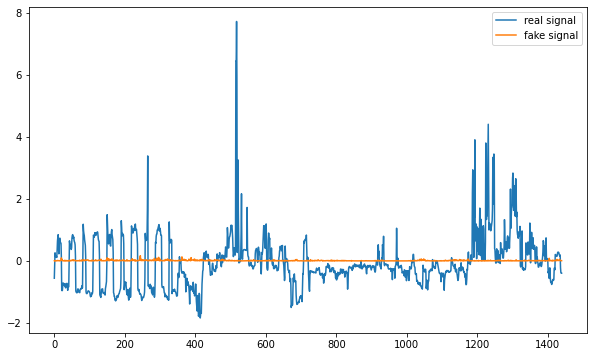

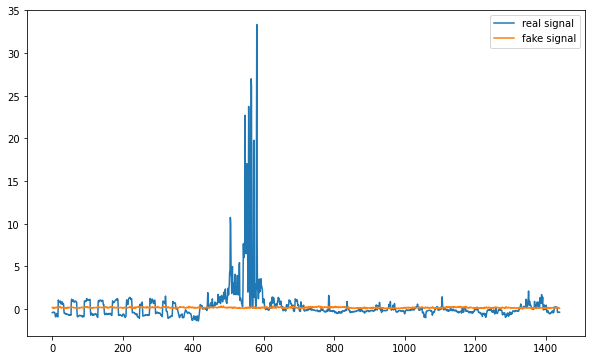

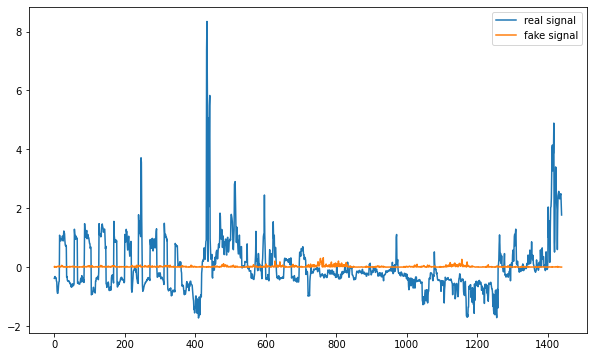

In [49]:
for batch_idx, data in enumerate(test_loader):
    data = data.cuda()
    with torch.no_grad():
        recon_data, _, _ = vae(data)
        plt.figure(figsize=(10, 6))
        plt.plot(data.cpu().detach()[0], label='real signal')
        plt.plot(recon_data.cpu().detach()[0], label='fake signal')
        plt.legend()
        plt.show();

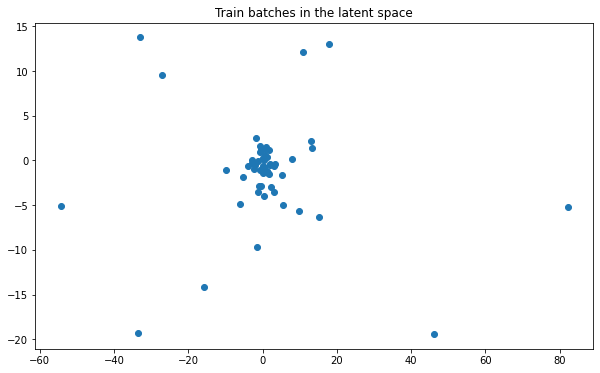

In [56]:
plt.figure(figsize=(10, 6))
for batch_idx, data in enumerate(train_loader):
    data = data.cuda()
    with torch.no_grad():
        z = vae.sampling(*vae.encoder(data)).cpu().detach()
        plt.scatter(z[:,0], z[:,1], color='tab:blue')

plt.title('Train batches in the latent space');

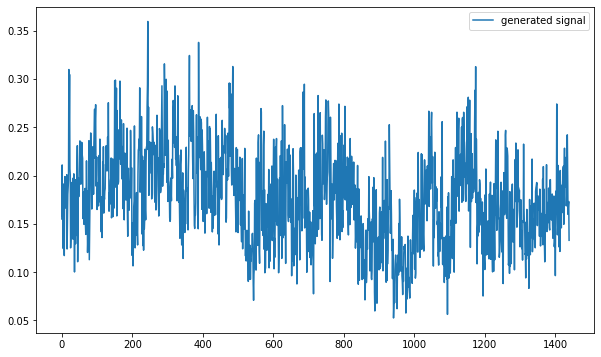

In [57]:
with torch.no_grad():
    z = torch.randn(1, 2).cuda()
    generated = vae.decoder(z.view(1,-1))
    # plot the two images
    plt.figure(figsize=(10, 6))
    plt.plot(generated.cpu().detach()[0], label='generated signal')
    plt.legend()
    plt.show();

# 3. Modèle GAN

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=g_input_dim, out_features=256, bias=True)
        self.fc2 = torch.nn.Linear(in_features=256, out_features=512, bias=True)
        self.fc3 = torch.nn.Linear(in_features=512, out_features=1024, bias=True)
        self.fc4 = torch.nn.Linear(in_features=1024, out_features=g_output_dim, bias=True)
    
    # forward method
    def forward(self, x): 
        A = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        A = F.leaky_relu(self.fc2(A), negative_slope=0.1)
        A = F.leaky_relu(self.fc3(A), negative_slope=0.1)
        gen = torch.tanh(self.fc4(A))
        return gen
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=d_input_dim, out_features=1024, bias=True)
        self.fc2 = torch.nn.Linear(in_features=1024, out_features=512, bias=True)
        self.fc3 = torch.nn.Linear(in_features=512, out_features=256, bias=True)
        self.fc4 = torch.nn.Linear(in_features=256, out_features=1, bias=True)
        self.dropout = torch.nn.Dropout(0.3)
    
    # forward method
    def forward(self, x):
        A = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        Ad = self.dropout(A)
        A = F.leaky_relu(self.fc2(Ad), negative_slope=0.1)
        Ad = self.dropout(A)
        A = F.leaky_relu(self.fc3(Ad), negative_slope=0.1)
        Ad = self.dropout(A)
        dis = torch.sigmoid(self.fc4(Ad))
        return dis

In [11]:
z_dim = 100

G = Generator(g_input_dim = z_dim, g_output_dim = 24*60).to(device)
D = Discriminator(24*60).to(device)

# loss
loss = torch.nn.BCELoss(reduction='sum')

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [12]:
def D_train(x): # x is a batch composed of images
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # we use 1 for real and 0 for fake
    # train discriminator on real
    x_real = x
    #     x_real = x.view(-1, 1, mnist_dim_sq, mnist_dim_sq)
        
    y_real = torch.ones(bs, 1).cuda() # ...
    x_real, y_real = Variable(x_real), Variable(y_real)

    D_output = D(x_real) # ...
    D_real_loss = loss(D_output, y_real) # ...
    

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).cuda())
    x_fake = G(z) # ... generate fake images
    y_fake = torch.zeros(bs, 1).cuda() # ... labels
    D_output = D(x_fake)
    D_fake_loss = loss(D_output, y_fake)
    
    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train():
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).cuda())
    y = torch.ones(bs, 1).cuda() # ...

    G_output = G(z) # ... look at the discriminiator function, this is similar
    D_output = D(G_output) # ...
    G_loss = loss(D_output, y) # ...

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [13]:
n_epoch = 15
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, x in enumerate(train_loader):
        x = x.cuda()
        loss_D = D_train(x) # ...
        D_losses.append(loss_D)
        loss_G = G_train() # ....
        G_losses.append(loss_G)

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/15]: loss_d: 5.146, loss_g: 2.658
[2/15]: loss_d: 4.179, loss_g: 2.411
[3/15]: loss_d: 2.393, loss_g: 3.984
[4/15]: loss_d: 2.240, loss_g: 5.170
[5/15]: loss_d: 5.765, loss_g: 2.842
[6/15]: loss_d: 5.467, loss_g: 9.430
[7/15]: loss_d: 4.658, loss_g: 8.502
[8/15]: loss_d: 5.651, loss_g: 4.709
[9/15]: loss_d: 2.017, loss_g: 6.350
[10/15]: loss_d: 2.098, loss_g: 5.056
[11/15]: loss_d: 2.198, loss_g: 4.993
[12/15]: loss_d: 1.950, loss_g: 5.033
[13/15]: loss_d: 1.672, loss_g: 5.748
[14/15]: loss_d: 1.494, loss_g: 4.996
[15/15]: loss_d: 1.872, loss_g: 4.668


In [ ]:
for batch_idx, data in enumerate(test_loader):
    data = data.cuda()
    with torch.no_grad():
        recon_data, _, _ = vae(data)
        plt.figure(figsize=(10, 6))
        plt.plot(data.cpu().detach()[0], label='real signal')
        plt.plot(recon_data.cpu().detach()[0], label='fake signal')
        plt.legend()
        plt.show();

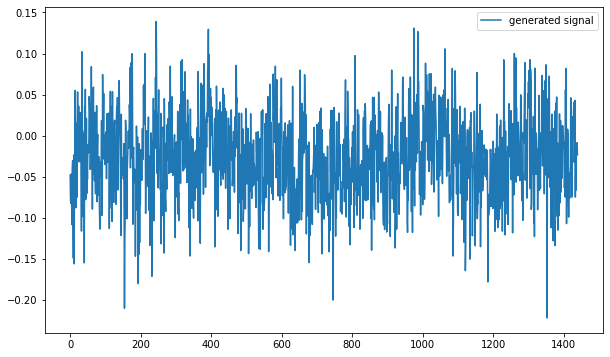

In [14]:
with torch.no_grad():
       test_z = Variable(torch.randn(bs, z_dim).cuda())
       generated = G(test_z)
       # plot the image
       plt.figure(figsize=(10, 6))
       plt.plot(generated.cpu().detach()[0], label='generated signal')
       plt.legend()
       plt.show();